# Classifiers

## Importing libraries/data

### Importing Libraries

In [1]:
# For general use
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# For our classifiers
from sklearn import neighbors
from sklearn import naive_bayes
from sklearn import tree
from sklearn import neural_network
from sklearn import preprocessing

# For confusion matrix/data importing
from sklearn import metrics  
from sklearn.datasets import load_digits 

from os import listdir
from os.path import isfile, join

from PIL import Image

import pickle

---
## Reading in Test Data
In this section of the notebook we read in all the images and convert them to a form that is acceptable by the classifier. To accomplish this, we must first get a list of file paths in our testing directories. After this, we will read in those images, and convert them to a classifier-acceptable numerical form.

### Getting list of Image Paths
Using `listdir`, `isfile`, and `join` from the `os`, we are able to get the paths of all our testing images as a list of strings. To avoid system files we remove any non-png files from the list.

In [2]:
symbols = [str(x) for x in range(10)]+["+", "-", "(", ")", ","]

file_lists = {}
for symbol in symbols:
    mypath =  "img/training/"+symbol
    file_lists[symbol] =  [mypath+"b/"+f for f in listdir(mypath+"b") if isfile(join(mypath+"b", f))]
    file_lists[symbol] += [mypath+"n/"+f for f in listdir(mypath+"n") if isfile(join(mypath+"n", f))]

    # Removing all non-png files
    for file in file_lists[symbol]:
        if(file[-4:] != ".png"):
            file_lists[symbol].remove(file)

### Loading in Images
Using the paths we just collected and PIL, we can load all of our test images

In [3]:
image_dict = {}
for symbol in symbols:
    image_dict[symbol] = []
    for file in file_lists[symbol]:
        image = Image.open(file)
        # Scaling image down
        image_dict[symbol].append(image.resize((45, 45)))

### Converting Each Image into an array

In [4]:
images_mono = {}
# Turning images into numerical values representing
#  brightness of each pixel
for symbol in symbols:
    images_mono[symbol] = []
    for i in image_dict[symbol]:
        images_mono[symbol].append(np.asarray( i, dtype="int32" ))

### Reshaping those arrays

In [5]:
images_shaped = images_mono.copy()

for symbol in symbols:
    for image in range(len(images_shaped[symbol])):
        images_shaped[symbol][image] = images_shaped[symbol][image].reshape(-1, 45**2)

### Combining data 

In [6]:
dfs = []
for symbol in symbols:
    print("Symbol: "+symbol)
    print("Creating DF")
    temp = pd.DataFrame([images_shaped[symbol][i][0] for i in range(len(images_shaped[symbol]))])
    temp["class"] = symbol
    dfs.append(temp)
    
df = pd.concat(dfs)


print("Done.")

Symbol: 0
Creating DF
Symbol: 1
Creating DF
Symbol: 2
Creating DF
Symbol: 3
Creating DF
Symbol: 4
Creating DF
Symbol: 5
Creating DF
Symbol: 6
Creating DF
Symbol: 7
Creating DF
Symbol: 8
Creating DF
Symbol: 9
Creating DF
Symbol: +
Creating DF
Symbol: -
Creating DF
Symbol: (
Creating DF
Symbol: )
Creating DF
Symbol: ,
Creating DF
Done.


## Test Train Split

In [7]:
features = [x for x in df]
features.remove("class")

train = df[df.index%2 == 0]
test = df[df.index%2 != 0]

train_X = np.array(train[features].values)
train_y = train["class"].values

test_X = np.array(test[features].values)
test_y = test["class"].values

all_X = np.array(df[features].values)
all_y = df["class"]

### Making a scaled copy of the data
Since our calssifiers were trained on scaled data, we will need to make a copy of our data that we will scale. This will allow us to test both our non-scaled trained and scaled trained classifiers at the same time

In [8]:
# Getting scaled copy of data
sc = preprocessing.StandardScaler()
sc_train_X = sc.fit_transform(train_X)
sc_test_X  = sc.fit_transform(test_X)
sc_all_X   = sc.fit_transform(all_X)

## Training classifiers


### Collecting accuracy vs data for classifiers

In [9]:
# Collecting scores for KNeighbors,
KN_scores = []
sc_KN_scores = []
for i in range(1, 10, 2):
    print("Neighbors =",i)
    clf_KN = neighbors.KNeighborsClassifier(n_neighbors=i)
    clf_KN.fit(train_X, train_y)
    KN_scores.append(clf_KN.score(test_X, test_y))
    clf_KN.fit(sc_train_X, train_y)
    sc_KN_scores.append(clf_KN.score(sc_test_X, test_y))
    
# Decision tree,
DT_scores = []
for i in range(1, 30):
    clf_DT = tree.DecisionTreeClassifier(max_depth=i, random_state=42)
    clf_DT.fit(train_X, train_y)
    DT_scores.append(clf_DT.score(test_X, test_y))
    
# GaussianNB,
clf_GA = naive_bayes.GaussianNB()
clf_GA.fit(train_X, train_y)
GA_score = clf_GA.score(test_X, test_y)

# and Neural Net
sc_NN_scores = []
NN_scores = []
for hid in range(1, 40, 5):
    print(f"fitting and scoring hidden_layer_sizes={hid}...")
    clf_NN = neural_network.MLPClassifier(hidden_layer_sizes=(hid),max_iter=3000, random_state=42)
    clf_NN.fit(train_X, train_y)
    NN_scores.append(clf_NN.score(test_X, test_y))
    
    clf_NN.fit(sc_train_X, train_y)
    sc_NN_scores.append(clf_NN.score(sc_test_X, test_y))

Neighbors = 1
Neighbors = 3
Neighbors = 5
Neighbors = 7
Neighbors = 9
fitting and scoring hidden_layer_sizes=1...
fitting and scoring hidden_layer_sizes=6...
fitting and scoring hidden_layer_sizes=11...
fitting and scoring hidden_layer_sizes=16...
fitting and scoring hidden_layer_sizes=21...
fitting and scoring hidden_layer_sizes=26...
fitting and scoring hidden_layer_sizes=31...
fitting and scoring hidden_layer_sizes=36...


### Comparing Data

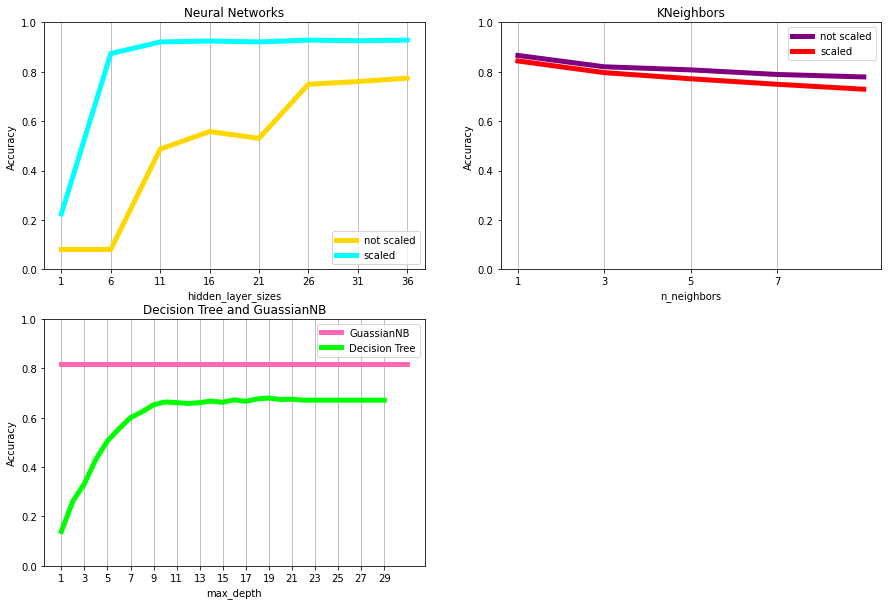

In [10]:
plt.figure(figsize=(15,10))

# First plot
plt.subplot(221)
plt.ylabel("Accuracy")
plt.xlabel("hidden_layer_sizes")
plt.plot(NN_scores, color="gold", lw=5, label="not scaled")
plt.plot(sc_NN_scores, color="cyan", lw=5, label="scaled")
plt.xticks([x for x in range(8)], labels=[hid for hid in range(1, 40, 5)])
plt.ylim((0,1))
plt.grid(axis="x")
plt.title("Neural Networks")
plt.legend()

# Second plot
plt.subplot(222)
plt.title("KNeighbors")
plt.ylabel("Accuracy")
plt.xlabel("n_neighbors")

plt.plot(KN_scores, color="purple", lw=5, label="not scaled")
plt.plot(sc_KN_scores, color="red", lw=5, label="scaled")

plt.xticks([x for x in range(4)], labels=[hid for hid in range(1, 10, 2)])
plt.ylim((0,1))
plt.grid(axis="x")
plt.legend()

# Third plot
plt.subplot(223)
plt.title("Decision Tree and GuassianNB")
plt.ylabel("Accuracy")
plt.xlabel("max_depth")

plt.plot([0,30], [GA_score]*2, color="hotpink", lw=5, label="GuassianNB")
plt.plot(DT_scores, color="lime", lw=5, label="Decision Tree")

plt.xticks([x for x in range(0, 30, 2)], labels=[hid for hid in range(1, 30, 2)])
plt.ylim((0,1))
plt.grid(axis="x")

plt.legend()
plt.show()

From the graphs it's pretty apparent that a Neural network trained on scaled data with `hidden_layer_sizes=11` works the best. Given this, this is the classifier we will use for our project.

### Outputting classifier

We will use the pickle library to store our Neural net in a file. This will allow us to just import it into our website, as opposed to retraining the net everytime the server restarts

In [12]:
# Putting Neural net into sc
sc_clf_NN = neural_network.MLPClassifier(hidden_layer_sizes=(11),max_iter=3000, random_state=42)
sc_clf_NN.fit(sc_all_X, all_y)
with open('clf.pk', 'wb') as fout:
    pickle.dump(sc_clf_NN, fout)

In [13]:
plt.

array([0, 0, 0, ..., 0, 0, 0])